# How is Transformer used in translation

## Translating "Hello World" to Chinese

### Stage 1
1. Pass "Hello World" to encoder
2. Pass "<start>" to decoder
3. Transformer outputs "你"

### Stage 2
1. Pass "Hello World" to encoder
2. Pass "你" to decoder
3. Transformer outputs "好"

### Stage 3
1. Pass "Hello World" to encoder
2. Pass "好" to decoder
3. Transformer outputs "世"

### Stage 4
1. Pass "Hello World" to encoder
2. Pass "世" to decoder
3. Transformer outputs "界"

In [11]:
# Multi-head Attention

print("word 'name' embedded and pos encoded into 512x1 vector.")
print("512x1 vector is pass to Q, K, V as 3 linear mapped copies.")
print("In 8 heads attentions architecture, 512x1 vector is chopped into 8 pieces with 64x1 each.")
print("This is done alone with other words in the sentence.\n")

print("Say hello to world")
print("embeded and pos encoded:             4x512")
print("Linear maps to Q K V:              3x4x512")
print("Attention unit starts")
print("In Q:                                4x512")
print("8 heads chopping:                     4x64")
print("Attention takes Q K V of 4x64:      3x4x64")
print("Attention generates new V:            4x64")
print("Attention generates Attn matrix:       4x4")
print("Concat all 8 new_V from 8 Attention: 4x512")
print("Goes to next layer...")

word 'name' embedded and pos encoded into 512x1 vector.
512x1 vector is pass to Q, K, V as 3 linear mapped copies.
In 8 heads attentions architecture, 512x1 vector is chopped into 8 pieces with 64x1 each.
This is done alone with other words in the sentence.

Say hello to world
embeded and pos encoded:             4x512
Linear maps to Q K V:              3x4x512
Attention unit starts
In Q:                                4x512
8 heads chopping:                     4x64
Attention takes Q K V of 4x64:      3x4x64
Attention generates new V:            4x64
Attention generates Attn matrix:       4x4
Concat all 8 new_V from 8 Attention: 4x512
Goes to next layer...


In [12]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

sequence_length = 4 # sentence length
batch_size = 1      # for parallel processing
input_dim = 512     # dim of word after embedding and pos encoding
d_model = 512       # output dim of multi head attn
x = torch.randn( (batch_size, sequence_length, input_dim) )
x.size()

torch.Size([1, 4, 512])

In [13]:
# Maps sequence to Q, K, V
qkv_layer = nn.Linear(input_dim, 3 * d_model) # Maps 512 to 3*512=1536 as QKV
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

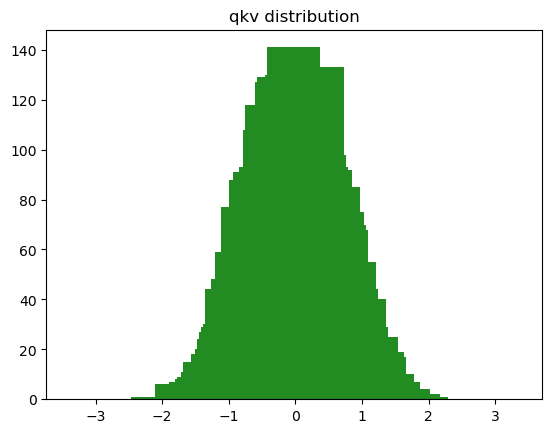

In [14]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [15]:
num_heads = 8
head_dim = d_model // num_heads # 512 / 8 = 64
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim) # 3 is from QKV
qkv.shape
# 192 = 64 * 3

torch.Size([1, 4, 8, 192])

In [16]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [17]:
# Seperate Q K V
q, k, v = qkv.chunk(3, dim=-1) # chop the last dimension (-1) into 3
(q.shape, k.shape, v.shape)

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [19]:
# Attention matrix
d_k = q.size()[-1] # should be 64=512/8 in our case
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k) # transpose between the second last (-2) and the last (-1) dimension
scaled.shape
# focus on the last 2 dim
# 4x64 dot 4x64^T = 4x4 attention matrix

torch.Size([1, 8, 4, 4])

In [25]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1) # tri will auto locate the last two dimension
print(mask[0][0])
print(mask[0][1])
print((scaled + mask)[0][0])

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])
tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])
tensor([[-0.4880,    -inf,    -inf,    -inf],
        [-0.2902, -0.0770,    -inf,    -inf],
        [ 0.0404,  0.3003,  0.0707,    -inf],
        [ 0.1488, -0.2462,  0.5967,  0.4996]], grad_fn=<SelectBackward0>)


In [27]:
# Softmax and mask
scaled += mask
attention = F.softmax(scaled, dim=-1) # apply softmax on last dimension which is row by row [1, 8, 4, 4]
attention[0][0] # softmax: [1][1] of the 4x4 attention will equal exp(scaled[1][0]) / (exp(scaled[1][0])+exp(scaled[1][1]))


tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4469, 0.5531, 0.0000, 0.0000],
        [0.3005, 0.3897, 0.3098, 0.0000],
        [0.2146, 0.1446, 0.3359, 0.3048]], grad_fn=<SelectBackward0>)

In [28]:
new_v = torch.matmul(attention, v)
new_v.shape

torch.Size([1, 8, 4, 64])

In [67]:
# My own implementation of multi headed attention

def multi_head_scaled_dot_product(Q, K, V, num_heads=8, mask=None):
    # Assume no batch here Q.shape -> [4, 512]
    # Also, 512 is after the word goes through the Linear mapping: input_dim -> d_model
    # Q, K, V can be 4x512 (4 words long sequence)
    d_model = Q.size()[-1]          # 512
    sequence_length = Q.size()[-2]  # 4

    # split heads
    head_dim = d_model // num_heads # 512 / 8 = 64
    Q = Q.reshape(sequence_length, num_heads, head_dim).permute(1, 0, 2) # [num_heads, sequence_length, head_dim]
    K = K.reshape(sequence_length, num_heads, head_dim).permute(1, 0, 2)
    V = V.reshape(sequence_length, num_heads, head_dim).permute(1, 0, 2)

    new_V = torch.tensor([[] for n in range(sequence_length)])
    Attn = torch.empty(0, sequence_length, sequence_length)
    # this part can be parallelize
    for q_h, k_h, v_h in zip(Q, K, V):
        # q_h.shape = [4, 64]
        d_k = q_h.size()[-1] # 64
        scaled = torch.matmul(q_h, k_h.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scaled += mask

        attn = F.softmax(scaled, dim=-1) # apply softmax row by row. attn: 4x4
        new_v = torch.matmul(attn, v_h)  # 4x64 -> needs to concat with other heads to form 4x512
        # do you add attn up for multi head attn return?
        new_V = torch.cat((new_V, new_v), -1) # 4x64 -> 4x512
        attn = attn.reshape(1, sequence_length, sequence_length)
        Attn = torch.cat((Attn, attn), 0) # 4x4 -> 8x4x4

    return new_V, Attn




In [46]:
# Better implementation of multi headed attention
import copy

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3*d_model)
        self.linear_layer = nn.Linear(d_model, d_model) # maps value vector to output

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f'x.size(): {x.size()}')
        qkv = self.qkv_layer(x)
        print(f'qkv.size(): {qkv.size()}')
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f'qkv.size(): {qkv.size()}')
        qkv = qkv.permute(0, 2, 1, 3)
        self.qkv = qkv.clone().detach() # for comparision
        print(f'qkv.size(): {qkv.size()}')
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = self.scaled_dot_product(q, k, v, mask)
        self.values = values.clone().detach() # for comparision
        self.attention = attention.clone().detach() # for comparision
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

    def scaled_dot_product(self, q, k, v, mask=None):
        d_k = q.size()[-1]
        scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
        if mask is not None:
            scaled += mask
        attention = F.softmax(scaled, dim=-1)
        values = torch.matmul(attention, v)
        return values, attention

    def get_qkv(self):
        return self.qkv.chunk(3, dim=-1)
    
    def get_value_attention(self):
        return self.values, self.attention
    

In [68]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

# qkv, new_v, attention from model
q, k, v = model.get_qkv()
M_value, M_attention = model.get_value_attention()
M_value = M_value[0]
M_attention = M_attention[0]

q = q[0].permute(1, 0, 2).reshape(sequence_length, d_model)
k = k[0].permute(1, 0, 2).reshape(sequence_length, d_model)
v = v[0].permute(1, 0, 2).reshape(sequence_length, d_model)

print()
print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")

# new_v, attention from my own implementation
values, attention = multi_head_scaled_dot_product(q, k, v, num_heads=num_heads)

M_value = M_value.permute(1, 0, 2).reshape(sequence_length, d_model)
print(M_value.shape)
print(values.shape)
print(M_value[0][0:4])
print(values[0][0:4])
print("Congrads! My own implementation of Multi Headed Attention is correct.")

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])

q size: torch.Size([5, 512]), k size: torch.Size([5, 512]), v size: torch.Size([5, 512]), 
torch.Size([5, 512])
torch.Size([5, 512])
tensor([0.2224, 0.0200, 0.6099, 0.0143])
tensor([0.2224, 0.0200, 0.6099, 0.0143])
Congrads! My own implementation of Multi Headed Attention is correct.
